<a href="https://colab.research.google.com/github/Evan-eng/anthropic_superposition_experiment_recreation/blob/main/demonstrating_superposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [209]:
import torch
import random
from torch import nn
import matplotlib.pyplot as plt
import numpy as np


In [210]:
# Define linear model where
# layer 1: h = Wx
# layer 2: x' = W^T h + b
class linear_model(nn.Module):
  def __init__(self, n, m):
    super(linear_model, self).__init__()
    self.layer1 = nn.Linear(n, m, bias=False)
    self.layer2 = nn.Linear(m, n)

  def forward(self, x):
    h = self.layer1(x)
    x_prime = self.layer2(h)
    return x_prime

  def set_layer2_weights(self):
    self.layer2.weight = nn.Parameter(self.layer1.weight.T)


# Define ReLU model where
# layer 1: h = Wx
# layer 2: x' = relu(W^T h + b)
class relu_model(nn.Module):
  # Create model here
  def __init__(self, n, m):
    super(relu_model, self).__init__()
    self.layer1 = nn.Linear(n, m, bias=False)
    self.layer2 = nn.Linear(m, n)
    self.relu = nn.ReLU()

  def forward(self, x):
    h = self.layer1(x)
    x_prime = self.relu(self.layer2(h))
    return x_prime

  def set_layer2_weights(self):
    self.layer2.weight = nn.Parameter(self.layer1.weight.T)


def loss(x, x_prime, importance):
    return torch.sum(importance * (x - x_prime))

features = 20  # n
hidden = 5  # m
s = 0.0
I = 0.7

In [211]:
# Generate a feature vector x where x_i = 0 with p(s) and is otherwise uniformly
# distributed between [0, 1]
def x_input(n, s):
    elements = torch.zeros(n)
    for i in range(n):
        if random.random() >= s:
            elements[i] = random.uniform(0, 1)
    return elements

# Generate importance tensor where I_i = 0.9 ^ i
def importance(n, I):
  tensor = torch.pow(torch.tensor(I), torch.arange(n))
  return tensor

In [212]:
linear_model = linear_model(features, hidden)
linear_model.set_layer2_weights()

x = x_input(features, s)
imp = importance(features, I)
x_prime = linear_model.forward(x)


# Optimizer and loss section
optimizer = torch.optim.AdamW(linear_model.parameters(), lr=1e-3)
optimizer.zero_grad(set_to_none=True)
total_loss = loss(x, x_prime, imp)
optimizer.zero_grad()
total_loss.backward()
optimizer.step()

# print(linear_model.layer1.weight)
# print(linear_model.layer2.weight)
# print(linear_model.layer2.bias)

W1 = linear_model.layer2.weight.detach().numpy()
linear_result = np.dot(W1, W1.T)
linear_norm = np.linalg.norm(linear_result)

# print(linear_result)
# print(linear_norm)


In [213]:
relu_model = relu_model(features, hidden)
relu_model.set_layer2_weights()

x = x_input(features, hidden)
imp = importance(features, I)
x_prime = relu_model.forward(x)


optimizer = torch.optim.AdamW(relu_model.parameters(), lr=1e-3)
optimizer.zero_grad(set_to_none=True)
total_loss = loss(x, x_prime, imp)
optimizer.zero_grad()
total_loss.backward()
optimizer.step()

# print(relu_model.layer1.weight)
# print(relu_model.layer2.weight)
# print(relu_model.layer2.bias)

W2 = relu_model.layer2.weight.detach().numpy()
relu_result = np.dot(W2, W2.T)
relu_norm = np.linalg.norm(relu_result)

# print(relu_result)
# print(relu_norm)

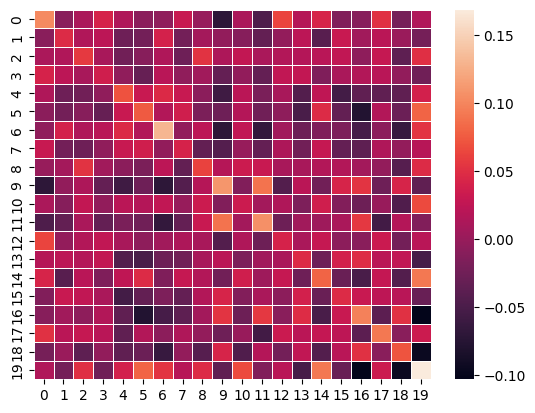

In [214]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

ax = sns.heatmap(relu_result, linewidth = 0.5)
plt.show()

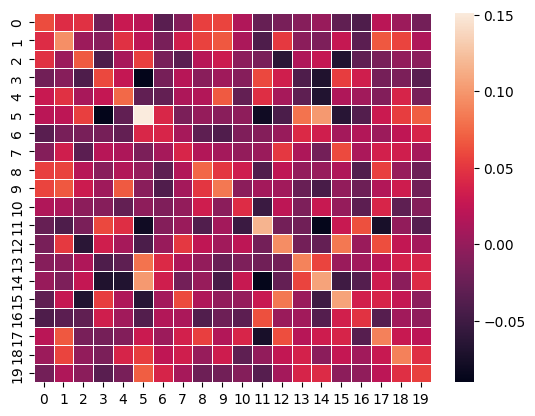

In [215]:
ax = sns.heatmap(linear_result, linewidth=0.5)
plt.show()